### Juan David Orjuela - María Sofía Álvarez López

<h1 align='center'>Laboratorio 2: Machine Learning Techniques</h1>

## Problema 
Una de las ventajas que ha brindado la tecnología y la globalización es poder encontrar diferentes referencias de diferentes productos, en especial si son productos de e-commerce, eventos de entretenimiento o reserva de hoteles y parques. En este último, una de las plataformas con mayor interacción a la hora de calificar hoteles es TripAdvisor, ya que permite establecer comentarios sobre hoteles y otorgarles una calificación. 

Ante esta oportunidad de crecimiento turpistica, dada la reactivación económica, han decidido establecer un hotel para poder brindar atención a sus clientes. Y dado que su hotel es bastante nuevo, aún no tienen registros en las grandes plataformas de calificación hotelera, pero si tienen ya varios comentarios en Redes Sociales y quisieran entender cual sería esa posible calificación que tendrían. Para ellos, los expertos en el mercado hotelero le han brindado la información de las reseñas de 2016 de TripAdvisor junto a sus calificaciones.<br>

Ellos han realizado una pre-exploración de los datos, y se han dado cuenta que las calificaciones se encuentran desbalanceadas. Por lo que le han recomendado utilizar una **SVM** para poder combatir este problema, dado que les interesaría con gran importancia saber si la calificación del hotel es muy baja.

También, alguno de sus compañeros Analistas de Datos, al ver que el problema es de textos. Le recomendó utilizar un **modelo estadístico**, con el fin de establecer una primera aproximación que les pueda ayudar a entender mejor el problema.

Y por último, dada su investigación que ha realizado sobre técnicas de Aprendizaje de Datos, ha establecido que las **Redes Neuronales Artificiales** pueden brindar un buen modelo que ayude a generalizar este análisis de sentimientos.

In [1]:
# ESAI
import inflect
import numpy as np
import contractions
import pandas as pd
from sklearn.svm import SVC
from joblib import dump, load
import re, string, unicodedata
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from nltk import word_tokenize, sent_tokenize
from sklearn import feature_extraction, feature_selection
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.stem import LancasterStemmer, WordNetLemmatizer, SnowballStemmer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, MaxAbsScaler
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve, make_scorer, f1_score

## 1. Entendimiento del problema
Lo primero que hacemos es cargar las librerías y el conjunto de datos, con el fin de entender las particularidades del problema que estamos enfrentando.

In [2]:
reviews = pd.read_csv('reviews.csv', delimiter=',')

Con esto, podemos ver una muestra de los datos. Aquí, nos damos cuenta que nuestro conjunto de datos consiste de dos columnas: "Review", con las reseñas de los clientes (escritas en inglés), y "Rating", con la calificación que el cliente asignó de acuerdo con su visita al hotel. Asimismo, vemos que tenemos 20491 reseñas.

In [3]:
print("Tamaño del conjunto de datos:", len(reviews))
reviews.sample(5)

Tamaño del conjunto de datos: 20491


,Review,Rating
16430,"great hotel beware banana skins, best hotels s...",5
14105,design sophisticted hotel not easy nice differ...,5
8643,not good expected small old rooms not worth pr...,2
2204,great location great starting point arrived se...,4
14735,"great place no lie, going hotel not listen neg...",4


Las calificaciones están dadas en un rango de 1-5. A priori, leyendo algunas de las reseñas y de acuerdo con la información de la plataforma, sabemos que una puntuación de 1 es muy mala y una de 5 es excelente.

In [4]:
reviews['Rating'].unique()

array([4, 2, 3, 5, 1])

Ahora queremos ver si nuestro conjunto de datos tiene entradas nulas. Para ello, revisamos si hay reseñas que correspondan con la cadena vacía "" o con un sólo espacio " ". Se ve que no hay ninguna con estas características, pues obtenemos un <i>dataframe</i> vacío, como vemos en la celda a continuación. Podemos hacer también una revisión con el método <code>isna()</code> de <code>pandas</code>. Este indica si hay algún valor de los datos que tenga como valor <code>None</code> o <code>numpy.NaN</code>. Vemos entonces que nuestro conjunto de datos no tiene ni nulos, ni faltantes.

In [5]:
print(reviews.isna().sum())
reviews[(reviews['Review'] == "") | (reviews['Review'] == " ")]

Review    0
Rating    0
dtype: int64


,Review,Rating


Nos damos cuenta ahora de que sólo tenemos una variabe (la reseña) y que la variable objetivo (target) es la puntuación dada por el usuario. Así las cosas partimos el conjunto de datos entre los datos de entrenamiento y de test: esto es crucial, pues, tras entrenar el modelo, debemos validarlo con datos que este nunca había visto. De acuerdo con el libro de Gerón <a href='#geron'>[1]</a>, una buena división entre datos de entrenamiento y test es 80% y 20%, respectivamente, y en consecuencia es la que usaremos para toda esta exploración.

In [6]:
X, Y = reviews['Review'], reviews['Rating']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,stratify=Y,test_size=0.2, random_state=48)

Con esto, procedemos a hacer todo el entrenamiento sobre el conjunto de $X_{\mathrm{train}},Y_{\mathrm{train}}$ y guardamos el test en la "caja fuerte" hasta que sea el momento de la validación.

Queremos ver la distribución de las clases de nuestro conjunto de datos. Para ello, consideremos el siguiente histograma.

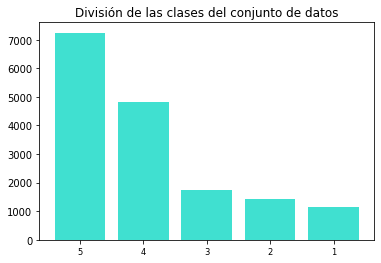

In [7]:
val_counts_y = Y_train.value_counts()
plt.bar(range(len(val_counts_y)), val_counts_y.values, align='center',color='turquoise')
plt.xticks(range(len(val_counts_y)), val_counts_y.index.values, size='small')
plt.title('División de las clases del conjunto de datos')
plt.show()

Podemos ver claramente que, como sugiere el enunciado, las clases están notablemente desbalanceadas. Primero que todo, de acuerdo con el enunciado del problema, esto resulta en un inconveniente puesto que precisamente nos interesan las reseñas más bajas (podríamos considerar estas como las clases 1 y 2, incluso la 3), pero estas son las clases minoritarias. Por lo tanto debemos utilizar técnicas de balanceo de clases. Podemos abordar este problema desde el preprocesamiento, usando técnicas de oversampling como SMOTE, o en la implementación del algoritmo, diciéndole que estamos trabajando con clases desbalanceadas. Quisiéramos ver ambos comportamientos, entonces intentaremos explorar ambas alternativas. Esto se realiza más adelante, en las secciones de preprocesamiento y modelado (respectivamente) de este documento.

---
Como parte final de esta exploración de los datos, queremos ver (a priori) cuáles son las palabras más utilizadas en el conjunto de datos. Para ello, usamos la librería <code>WordCloud</code>.

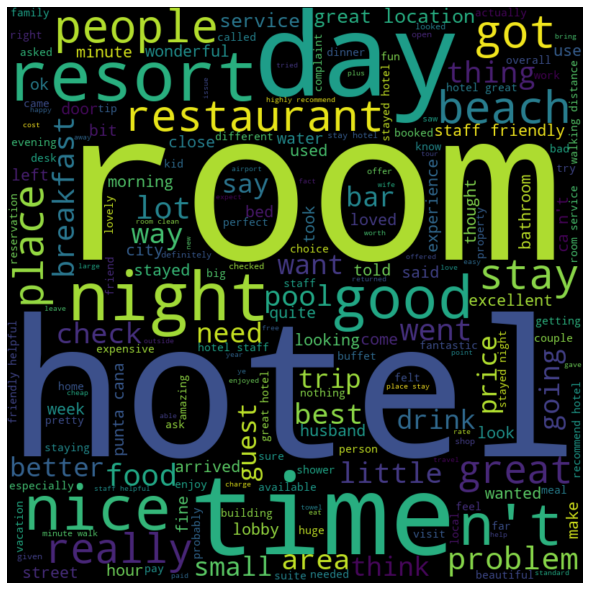

In [8]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,min_font_size = 10).generate(" ".join(data.values))                       
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show()
    return wordcloud

wc = wordCloud_generator(X_train)
wc

En esta nube de palabras no hay mayores sorpresas: encontramos mayoritariamente términos que esperaríamos encontrar en reseñas de hoteles. Note que las palabras "nice", "good", "great" y "friendly", entre otras, saltan a la vista. Esto confirma que, en efecto, hay varias críticas positivas (confirmando el desbalance en los datos).

## 2. Preprocesamiento

### 2.1 Eliminación de palabras no informativas
Antes de hacer cualquier preprocesamiento de los datos asociado a la tokenización y eliminación de palabras no informativas,vimos que en la nube de palabras obtuvimos como una de las "palabras" más comunes a "n't". Sabemos que esta es la contracción de la negación para expresiones como: can't, don't, doesn't, didn't y couldn't, entre otras. Explorando más a fondo el conjunto de datos, nos dimos cuenta de que había una separación extraña entre estas palabras. Por ejemplo, "can't" estaba escrito como "ca n't". Esto podría representar un problema más adelante. Por ejemplo, al realizar el preprocesamiento posterior, si tokenizamos por palabras, se separaría en dos tokens diferentes (y ca no tiene sentido por sí sola). 

Investigando un poco, encontramos que las contracciones más comunes que finalizan en n't en inglés son las que se encuentran en el diccionario a continuación.

In [9]:
our_contractions = { 
"ai n't": "am not",
"are n't": "are not",
"ca n't": "cannot",
"could n't": "could not",
"did n't": "did not",
"does n't": "does not",
"do n't": "do not",
"had n't": "had not",
"has n't": "has not",
"have n't": "have not",
"is n't": "is not",
"may n't": "may not",
"might n't": "might not",
"must n't": "must not",
"need n't": "need not",
"ought n't": "ought not",
"sha n't": "shall not",
"sha' n't": "shall not",
"should n't": "should not",
"was n't": "was not",
"were n't": "were not",
"wo n't": "will not",
"would n't": "would not",
}

def change_contractions(series, our_contractions):
    return series.replace(our_contractions, regex=True)

Asimismo, leyendo algunas de las reseñas, nos dimos cuenta que había algunos caracteres no-ASCII. Por ejemplo, en una reseña en lugar de decir "piña coladas" decía "piëÙ_a coladas". Otros ejemplos extraños que encontramos (seguramente por errores en las tildes o apóstrofes usados) fueron: wasn_Çé_, cafÄ au lait, o_Çéælock (que probablemente se refirieran a _wasn't_, _café au lait_ y _o'clock_, respectivamente). Para esto, definimos una función que elimine los caracteres no-ASCII para las palabras (tokens) de cada documento del corpus.

In [10]:
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

Asimismo, es importante que todas las palabras tengan una capitalización homogénea (en este caso, queremos que estén en minúscula). 

In [11]:
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

Por otro lado, consideramos que la puntuación no provee información adicional en este contexto. Adicionalmente, de no eliminarse, puede aumentar la dimensionalidad de los datos sin proveer más información. Por ejemplo, no tiene sentido pensar que "almuerzo!" y "almuerzo" sean palabras diferentes. Por ello removemos toda la puntuación usando expresiones regulares.

In [12]:
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

Ahora, podemos suponer que los números no proveen información relevante para el problema en cuestión. Por ejemplo, hay precios que no se repetirán con frecuencia entre los documentos, porque pueden referirse a productos diferentes (o en monedas diferentes) o a visitas en años o temporadas diferentes (con el consecuente cambio en los precios). Por ejemplo, si una reseña dice algo como: "Eso estaba muy costoso, su precio era de 18.50", es suficiente con quedarnos con la parte de que era muy costoso. Asimismo, consideramos que palabras que incluyan números (por ejemplo "250/night" son irrelevantes para el problema pues la frecuencia de repetición será muy baja. Podemos, entonces, eliminarlas.

In [13]:
def remove_numbers(words):
    p = inflect.engine()
    new_words = []
    for word in words:
        new_word = re.sub('\d+.*', '', word)
        if not word.isnumeric() and new_word != '':
            new_words.append(word)
    return new_words

Por un argumento similar, podemos eliminar las fechas de estadía que algunos clientes hayan podido incluir en sus reseñas. Esto es información irrelevante, sin el contexto adecuado (por ejemplo añadiendo una serie de tiempo), para el análisis de sentimientos. 

In [14]:
def remove_dates(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'\d+/\d+/\d+', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

Como última etapa del preprocesamiento, eliminamos las palabras que no contribuyen al contexto. Para ello, usamos dos listas. Primero, usamos las "stop words" características del inglés, usando el módulo <code>stopwords</code> de la librería <code>nltk</code>. 

La otra lista corresponde a las palabras de mayor frecuencia entre los documentos del corpus que consideramos no aportan significativamente al análisis de sentimientos. Veamos las 10 primeras palabras que obtuvimos de la nube de palabras que hicimos en el preprocesamiento.

In [15]:
print(list(wc.words_.keys())[:10])
our_stopwords = list(wc.words_.keys())[:6] + ['rooms']

['room', 'hotel', 'day', 'time', 'resort', 'night', 'nice', 'good', "n't", 'people']


Vemos que las 6 primeras palabras son demasiado generales y aplican a cualquier tipo de reseña sin emitir un juicio de valor que nos permita relacionarlo con el puntaje asignado por el usuario. No obstante, "nice" y "good" sí informan sobre la experiencia. Podemos catalogar como "stop-words" a las 6 primeras palabras de esta lista y eliminarlas de nuestro conjunto de datos.

In [16]:
def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords.words('english') and word not in our_stopwords:
            new_words.append(word)
    return new_words

Finalmente, definimos una función con todos los pasos de eliminación del ruido que definimos previamente. 

In [17]:
def noise_elimination(words):
    words = to_lowercase(words)
    words = remove_non_ascii(words)
    words = remove_numbers(words)
    words = remove_dates(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

Con esto, ya tenemos casi listo nuestro proceso de eliminación del ruido. Primero, arreglamos las contracciones de palabras separadas como "ca n't" que encontramos. Luego, llamamos a la función <code>fix</code> de la librería <code>contractions</code> para aquellas contracciones que no están separadas en dos palabras. Esta elimina todas las ocurrencias de contracciones en inglés, reemplazándolas por su equivalente sin contracción. Una vez realizado este paso, "tokenizamos" las reseñas. Para poder evaluar cada palabra por separado y aplicar los pasos de preprocesamiento, hacemos la tokenización en palabras individuales usando el módulo <code>word_tokenize</code>. Finalmente, aplicamos la función <code>noise_elimination</code> definida previamente.

Más adelante, lo que realmente nos servirá será volver a tener los documentos sin tokenización para el proceso de vectorización _tf-idf_. Entonces, volvemos a juntar todas las palabras para cada documento y retornamos eso. También retornamos las palabras tokenizadas con el fin de realizar la lematización estemización más adelante.

In [18]:
def preprocessing(X):
    new_X_train = change_contractions(X, our_contractions) 
    new_X_train= X.apply(contractions.fix) #Aplica la corrección de las contracciones
    new_X_train = new_X_train.apply(word_tokenize)
    new_X_train = new_X_train.apply(noise_elimination) #Aplica la eliminación del ruido
    X_train = new_X_train.apply(lambda x: ' '.join(map(str, x)))
    return new_X_train, X_train

Veamos cómo va hasta ahora nuestro conjunto de datos,

In [19]:
tokenized, non_tokenized = preprocessing(X_train)

In [20]:
non_tokenized.sample(5)

16642    stinky place sold home travel agent acceptable...
7135     anniversary loved ride airport mins good thing...
7372     nice surprise stay surprised value quality reg...
7389     pleased drury returned stay drury inn excellen...
18156    great location adults spent nights june locati...
Name: Review, dtype: object

Después de esta eliminación de ruido y de palabras no informativas, veamos cuáles son las palabras de mayor uso en el conjunto de datos.

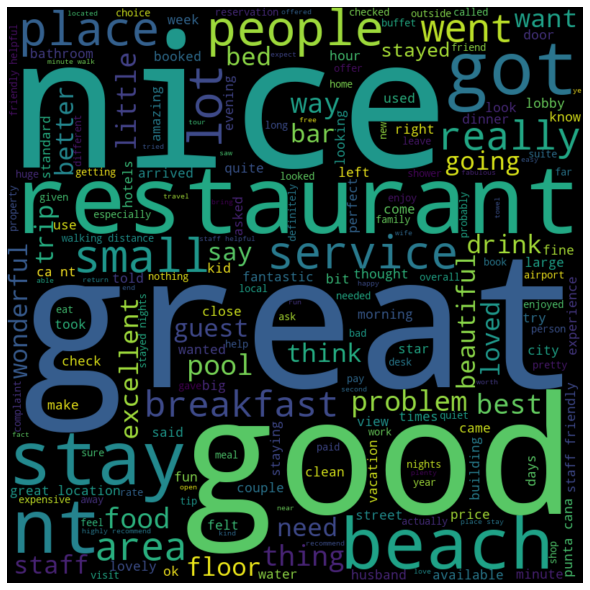

In [21]:
wordCloud_generator(non_tokenized) 

Vemos que, ahora, resaltan palabras como: "good, nice y great". Estas sí brindan más información del contexto, pero también indican (como habíamos visto previamente) que hay un desbalance de clases. El hecho de que resalten palabras positivas está asociado a calificaciones más altas por parte de los usuarios. Para ello, se hace necesario el balanceo de clases. Con esto, finalizamos la etapa de limpieza y eliminación de palabras no informativas.

---

### 2.2 Normalización: Stemming y Lematización
En esta parte del preprocesamiento, hacemos una eliminación de prefijos y sufijos, así como una lematización de los verbos. En el caso del Stemming hay varios algoritmos que podemos utilizar: Porter, Snowball (Porter2) o Lancaster (Paice-Husk). De acuerdo a lo que encontramos, <a href='https://stackoverflow.com/questions/10554052/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-alg'>la agresividad en el corte de raíces de las palabras de estos algoritmos aumenta, siendo Porter el menos agresivo y Lancaster el más agresivo </a>. En este sentido, parece ser que Lancaster (a pesar de ser el más eficiente de todos), puede ser poco riguroso y así crear muchas ambigüedades. Asimismo, Porter2 es un poco más agresivo que Porter, sin perder mucho el origen de las palabras y con un tiempo de cómputo razonable. El mismo Porter, creador del algoritmo, argumenta que es una mejora de su algoritmo original. Con el fin de tener la mejor preparación de las palabras, en un tiempo de cómputo razonable, decidimos usar Porter2. En el caso de la lematización, sí usamos <code>WordNetLemmatizer()</code> al ser el más usado en el mundo del procesamiento de textos.

In [22]:
def stem_words(words):
    stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

def join_stem_and_lemmatize(tokenized):
    return tokenized.apply(lambda x: ' '.join(map(str, x)))

tokenized = tokenized.apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
non_tokenized = join_stem_and_lemmatize(tokenized)
# Vemos el inicio de nuestro nuevo conjunto 
tokenized.sample(5)

6718     [honest, truth, grand, oasi, famili, stay, gra...
10334    [great, florenc, great, disast, lodg, romethi,...
19542    [locat, locat, locat, situat, right, time, squ...
13766    [fantast, heart, frisco, total, love, wish, ri...
10307    [earli, chrisma, visit, true, dlrp, fan, visit...
Name: Review, dtype: object

Veamos cómo nos quedó la nube de palabras después de esta tokenización,

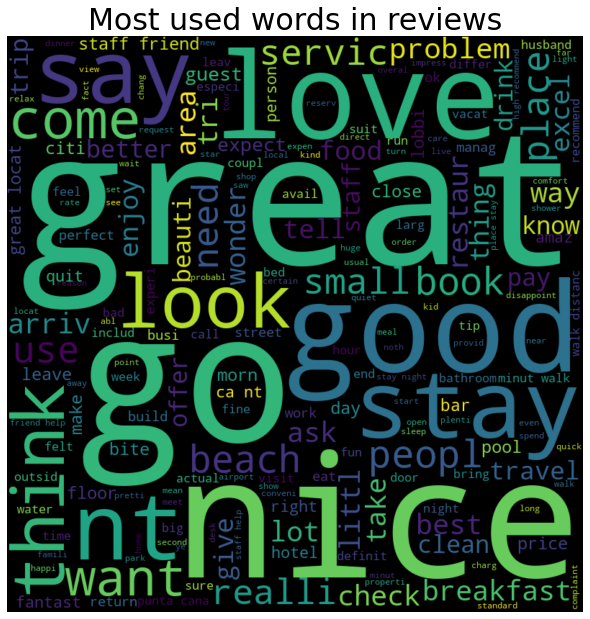

In [23]:
wordCloud_generator(non_tokenized, title="Most used words in reviews")

### 2.3 Generación de vectores
Para el proceso de vectorizar las entradas decidimos simplificar las opciones, limitando a que el modelo reciba tokens de palabras individuales (posteriormente algunos modelos podrán explorar 2-gramas o 3-gramas, dependiendo de las posibilidades computacionales). Por lo tanto se escogió TF-iDF para este paso. Las motivaciones detrás de esta elección son variadas. Lo primero es su notable superioridad ante modelos como _bag-of-words_ que no tienen en cuenta la importancia relativa de una palabra dentro del corpus. TF-iDF además se comporta muy bien con las familias de modelos que exploraremos para este problema, a saber Naïve Bayes, MLP y especialmente SVM, como muestran Cahyani et al. <a href='#Cahyani'>[2]</a>.

In [24]:
def vectorize(non_tokenized, ini=1, fini=1):
    tf_idf = TfidfVectorizer(ngram_range=(ini, fini))
    X_tf_idf = tf_idf.fit_transform(non_tokenized)
    return tf_idf, X_tf_idf

Según lo propuesto para este ejercicio, debemos realizar, por un lado, reducción de dimensionalidad y, por otro lado, balanceo de clases. 

Empecemos por definir la reducción de dimensionalidad.

### 2.4 Reducción de dimensionalidad
Para reducir la dimensionalidad decidimos usar $\chi ^2$ en lugar de PCA. La razón es que para problemas de procesamiento de lenguaje natural se obtienen matrices grandes y muy dispersas, lo que eleva rápidamente eleva el costo computacional de hacer un procesamiento como el de PCA. $\chi ^2$ nos permite hacer algo similar con mucho menos esfuerzo computacional, dejando los features realmente sean estadísticamente significativos. Para acotar el número de features elegimos un _P value_ entre 0.95 y 0.90, lo que nos da una buena probabilidad de que los features  elegidos no sean independientes de la variable objetivo. 

In [25]:
def dimensionality_reduction(tf_idf, X_tf_idf, Y_train, non_tokenized, limit=0.95):
    X_names = tf_idf.get_feature_names()
    p_value_limit = limit #Hiperparametro 
    dtf_features = pd.DataFrame()
    for cat in np.unique(Y_train):
        chi2, p = feature_selection.chi2(X_tf_idf, Y_train==cat)
        dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
        dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
        dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
    X_names = dtf_features["feature"].unique().tolist()
    # Podemos visualizar las 10 features elegidas más importantes por categoría
    for cat in np.unique(Y_train):
        print("# {}:".format(cat))
        print("  . selected features:", len(dtf_features[dtf_features["y"]==cat]))
        print("  . top features:", ",".join(
    dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
    print(" ")
    # Finalmente, pasamos las features más relevantes a TF-IDF 
    tf_idf = TfidfVectorizer(vocabulary=X_names)
    X_tf_idf = tf_idf.fit_transform(non_tokenized)
    return X_tf_idf

In [26]:
tf_idf, X_tf_idf = vectorize(non_tokenized)
X_tf_idf_dim_red = dimensionality_reduction(tf_idf, X_tf_idf, Y_train, non_tokenized, limit=0.95)

# 1:
  . selected features: 657
  . top features: dirti,horribl,rude,terribl,worst,disgust,dump,filthi,tell,manag
# 2:
  . selected features: 328
  . top features: tell,poor,great,disappoint,rude,ok,terribl,smell,excel,okay
# 3:
  . selected features: 107
  . top features: ok,averag,okay,love,bad,basic,wonder,fantast,decent,noth
# 4:
  . selected features: 45
  . top features: good,nice,valu,pretti,clean,dirti,locat,worst,great,terribl
# 5:
  . selected features: 317
  . top features: fantast,wonder,excel,perfect,love,ok,dirti,bad,tell,worst
 


Con un _P value_ de 0.95 logramos reducir bastante la dimensionalidad hasta 3094. Al hacer una inspección, se ve bastante razonable los features que encontró como más significativos: para cinco, las máxima calificación, encontró features como "excelente", "perfecto", "maravilloso", "fantástico". Para cuatro "bueno", "agradable", "bonito", "limpio". Para calificaciones regulares, con puntaje de tres, encontró "OK", "promedio", "básico", "decente". Y finalmente para las calificaciones negativas, con dos estrellas, "pobre", "decepcionante", "grosero", "olor", hasta las más negativas (de una estrella), con palabras como "sucio", "horrible", "terrible", "peor", "basurero" y "asco/asqueroso".

In [27]:
X_tf_idf_dim_red.shape

(16392, 1101)

### 2.5 Oversampling con SMOTE para balanceo de clases

Habiendo vectorizado nuestro conjunto de datos, procedemos a hacer re-muestreo para eliminar el problema de desbalance de clases. Elegimos hacer SMOTE en lugar de undersampling, pues, aunque tenemos un set de datos considerable, no queremos disminuir nuestro espacio de muestreo de una forma tan voraz. Así las cosas, aplicamos el algoritmo de SMOTE sobre la matriz producto de la vectorización con TF-iDF.

In [28]:
def balanceo_de_clases(X_tf_idf, Y_train):
    oversample = SMOTE(random_state=48)
    X_smote, Y_smote = oversample.fit_resample(X_tf_idf, Y_train)
    return X_smote, Y_smote

In [29]:
X_smote, Y_smote = balanceo_de_clases(X_tf_idf_dim_red, Y_train)

Como podemos ver abajo, ahora las clases están perfectamente balanceadas.

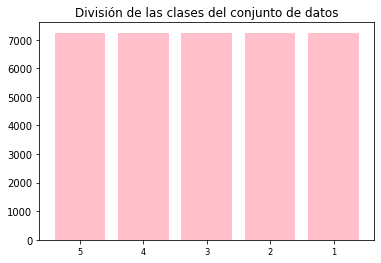

In [30]:
val_counts_y = Y_smote.value_counts()
plt.bar(range(len(val_counts_y)), val_counts_y.values, align='center',color='pink')
plt.xticks(range(len(val_counts_y)), val_counts_y.index.values, size='small')
plt.title('División de las clases del conjunto de datos')
plt.show()

Con este último paso ya tenemos todo el preprocesamiento listo para empezar a construir nuestros diferentes modelos. Las pipelines se organizarán previo a cada modelo, pues las particularidades de cada familia nos sugieren que es mejor preparar para cada caso de manera independiente. 

## 3. Modelado

Para la selección de los modelos, usaremos la métrica F1 (media armónica) que muestra un balance entre el recall y la precisión. En este caso, no nos interesa una métrica sobre la otra. Lo que queremos es reproducir con la mayor fidelidad posible la relación entre un comentario y la puntuación dada por un usuario. 

In [31]:
# Primero, hacemos TODO el preproc hasta stem y lemmatize. Esto es igual para todos los algoritmos.
tokenized, non_tokenized = preprocessing(X_train)
tokenized = tokenized.apply(stem_and_lemmatize)
X_train = join_stem_and_lemmatize(tokenized)

## 3.1 SVM
Empezamos a entrenar modelos de la familia de los SVM pues parecen particularmente bien portados para la clasificación de textos. Una de sus características es que funcionan muy bien para datos de alta dimensionalidad. Para nuestro problema contamos con un conjunto de datos de tamaño no despreciable, por lo que eso podría ser una limitante al momento de entrenar las SVM (pues no escalan muy bien con el número de datos) y algo que tendremos que tener en cuenta. Lo bueno es que las SVM son capaces de construir froteras muy complejas para separar los conjuntos de datos (siempre de forma binaria, usando el acercamiento one-versus-one en el caso de la implementación de sklearn de Python). Dado que usamos TF-iDF para construir los vectores, no se hace necesario normalizar los datos (ya vienen entre 0 y 1 por construcción), que de otra manera sería fundamental para entrenar las SVM. Finalmente, en nuestro caso nos permite balancear los datos de dos manera: con SMOTE o directamente en el algoritmo, usando una SVM con costo. 

---
### 3.1.1 Original
Aquí no implementamos balanceo ni reducción de dimensionalidad. Construimos la pipeline únicamente hasta TF-IDF. Nos preocupamos únicamente por elegir la cantidad de n-gramas que dan el mejor rendimiento (sólamente unigramas o bigramas). Nos quedamos con el resto de valores por defecto de SVC() debido a que el poder de cómputo es limitado y este modelo resultó particularmente costoso. Como parámetro de regularización C usamos 0.5, para evitar el overfitting.

Asimismo, sabemos que el número de n-gramas que recibe el algoritmo TF-IDF puede considerarse un hiperparámetro. Para ello, corrimos un modelo (que no ponemos aquí, pues se demoró 2 horas) en que obtuvimos que, para la SVM original, entre usar sólo palabras y usar palabras y digramas, la mejor combinación era usar sólo palabras (i.e. monogramas). Esto se muestra a continuación.

In [ ]:
estimators = [('transform', TfidfVectorizer(ngram_range=(1, 1))),
             ('clf', SVC(C=0.5))]
pipe = Pipeline(estimators)
SVM_original = pipe.fit(X_train, Y_train)
dump(SVM_original, 'svm_original.joblib') 

In [32]:
svm_model_original = load('svm_original.joblib') 

y_pred_SVM_original = svm_model_original.predict(X_train)
report_SVM_original = classification_report(Y_train, y_pred_SVM_original)
print("Test Report for original SVM\n", report_SVM_original)
print("Confusion Matrix for original SVM\n", confusion_matrix(Y_train, y_pred_SVM_original))

Test Report for original SVM
               precision    recall  f1-score   support

           1       0.98      0.80      0.88      1137
           2       0.83      0.75      0.79      1434
           3       0.95      0.19      0.32      1747
           4       0.69      0.72      0.71      4831
           5       0.79      0.96      0.87      7243

    accuracy                           0.78     16392
   macro avg       0.85      0.69      0.71     16392
weighted avg       0.80      0.78      0.76     16392

Confusion Matrix for original SVM
 [[ 913  132    4   46   42]
 [   6 1080   12  219  117]
 [   8   79  334 1007  319]
 [   0   15    0 3491 1325]
 [   1    3    0  281 6958]]


El modelo predice de forma bastante aceptable, excepto por la clase 3, probablemente debido al desbalance de las clases.

### 3.1.2 Con reducción de dimensionalidad
Para la reducción de dimensionalidad usamos $\chi ^2$ como expusimos previamente y dejamos los n_gramas obtenidos con el caso original (unigramas, i.e. palabras individuales). Entonces obtuvimos

In [33]:
tf_idf, X_tf_idf = vectorize(X_train, ini=1, fini=1)
X_tf_idf_dim_red = dimensionality_reduction(tf_idf, X_tf_idf, Y_train, X_train, limit=0.95)

# 1:
  . selected features: 657
  . top features: dirti,horribl,rude,terribl,worst,disgust,dump,filthi,tell,manag
# 2:
  . selected features: 328
  . top features: tell,poor,great,disappoint,rude,ok,terribl,smell,excel,okay
# 3:
  . selected features: 107
  . top features: ok,averag,okay,love,bad,basic,wonder,fantast,decent,noth
# 4:
  . selected features: 45
  . top features: good,nice,valu,pretti,clean,dirti,locat,worst,great,terribl
# 5:
  . selected features: 317
  . top features: fantast,wonder,excel,perfect,love,ok,dirti,bad,tell,worst
 


Dado que esperamos que obtendríamos rendimientos muy similares entre kernel lineal y RBF  <a href='#rbfvslin'>[3]</a>, limitamos a exploración a kernel polinomial de grado tres y rbf, disminuyendo así el costo computacional del GridSearch.


In [ ]:
estimators = [('clf',SVC(gamma='scale'))]

pipe_dim_reduction = Pipeline(estimators)

param_grid = dict(clf__C = [0.01, 0.1, 1],
                  clf__kernel = ['poly', 'rbf'],
                 )

grid_search_svm_dim_red = GridSearchCV(pipe_dim_reduction, param_grid=param_grid,cv=2,verbose=3,scoring='f1_weighted')
grid_search_svm_dim_red.fit(X_tf_idf_dim_red,Y_train)

In [ ]:
print(grid_search_svm_dim_red.best_params_)
dump(grid_search_svm_dim_red.best_estimator_, 'svm_dim_red.joblib') 

In [34]:
svm_model_dim_red = load('svm_dim_red.joblib') 
y_pred_SVM_dim_red = svm_model_dim_red.predict(X_tf_idf_dim_red)

In [35]:
report_SVM_dim_red = classification_report(Y_train, y_pred_SVM_dim_red)
print("Test Report for SVM with dim reduction\n", report_SVM_dim_red)
print("Confusion Matrix for SVM with dim reduction\n", confusion_matrix(Y_train, y_pred_SVM_dim_red))

Test Report for SVM with dim reduction
               precision    recall  f1-score   support

           1       0.94      0.92      0.93      1137
           2       0.88      0.87      0.88      1434
           3       0.93      0.69      0.79      1747
           4       0.81      0.79      0.80      4831
           5       0.86      0.93      0.90      7243

    accuracy                           0.86     16392
   macro avg       0.88      0.84      0.86     16392
weighted avg       0.86      0.86      0.86     16392

Confusion Matrix for SVM with dim reduction
 [[1050   64   10    9    4]
 [  37 1246   45   82   24]
 [  21   59 1199  368  100]
 [   7   31   18 3838  937]
 [   5   14   16  442 6766]]


El haber utilizado reducción de dimensionalidad acelera considerablemente el tiempo de entrenamiento, lo que a su vez nos permitió hacer un GridSearch que reporta resultados superiores (en métrica F1). Así mismo, esta reducción de features puede disminuir el número de vectores de soporte, reduciendo la complejidad del problema y el riesgo de overfitting.

### 3.1.3 Con SMOTE y reducción de dimensionalidad
Aquí usamos la función de Chi-cuadrado para la reducción de dimensionalidad, y dejamos los n_gramas obtenidos con el caso original. Lo que cambia 

In [ ]:
X_smote, Y_smote = balanceo_de_clases(X_tf_idf_dim_red, Y_train)

In [ ]:
estimators = [('clf',SVC(gamma='scale'))]

pipe_svm_SMOTE = Pipeline(estimators)

param_grid = dict(clf__C = [0.01, 0.1, 1],
                  clf__kernel = ['poly', 'rbf'],
                 )

grid_search_svm_SMOTE = GridSearchCV(pipe_svm_SMOTE, param_grid=param_grid,cv=2,verbose=3,scoring='f1_weighted')
grid_search_svm_SMOTE.fit(X_smote, Y_smote)

In [ ]:
print(grid_search_svm_SMOTE.best_params_)
dump(grid_search_svm_SMOTE.best_estimator_, 'svm_SMOTE.joblib') 

In [ ]:
svm_model_SMOTE = load('svm_SMOTE.joblib') 

y_pred_SVM_SMOTE = svm_model_SMOTE.predict(X_smote)
report_SVM_SMOTE = classification_report(Y_smote, y_pred_SVM_SMOTE)
print("Test Report for SVM with dim reduction and SMOTE\n", report_SVM_SMOTE)
print("Confusion Matrix for SVM with dim reduction and SMOTE\n", confusion_matrix(Y_smote, y_pred_SVM_SMOTE))

<b>NOTA:</b> Este algoritmo lo corrimos en otro computador. Por lo tanto, los resultados obtenidos se presentan en la imagen a continuación.
<img src='images/overfit_smote.jpg'></img>

Con puntaje F1 (y similarmente para casi todas las métricas) igual a 1, hay una altísima probabilidad de que nuestro modelo esté haciendo overfit. En consecuencia, reajustamos la búsqueda sobre los hiperparámetros reduciendo el valor de C para simplificar el modelo.

In [ ]:
estimators = [('clf',SVC(gamma='scale'))]

pipe_svm_SMOTE = Pipeline(estimators)

param_grid = dict(clf__C = [0.01, 0.1],
                  clf__kernel = ['poly', 'linear'],
                 )

grid_search_svm_SMOTE = GridSearchCV(pipe_svm_SMOTE, param_grid=param_grid,cv=2,verbose=3,scoring='f1_weighted')
grid_search_svm_SMOTE.fit(X_smote, Y_smote)

In [ ]:
print(grid_search_svm_SMOTE.best_params_)
dump(grid_search_svm_SMOTE.best_estimator_, 'svm_SMOTE_simplified.joblib') 

In [ ]:
svm_model_SMOTE = load('svm_SMOTE_simplified.joblib') 

y_pred_SVM_SMOTE = svm_model_SMOTE.predict(X_smote)
report_SVM_SMOTE = classification_report(Y_smote, y_pred_SVM_SMOTE)
print("Test Report for SVM with dim reduction, SMOTE and more regularization\n", report_SVM_SMOTE)
print("Confusion Matrix for SVM with dim reduction, SMOTE and more regularization\n", confusion_matrix(Y_smote, y_pred_SVM_SMOTE))

<b>NOTA:</b> Este algoritmo lo corrimos en otro computador. Por lo tanto, los resultados obtenidos se presentan en la imagen a continuación.
<img src='images/svm_smote_simplified.jpg'></img>

Este reporte es mucho más tranquilizador, con puntajes F1 bastante decentes para casi todas las clases (la única excepción podría ser la clase cuatro, cuyo bajo recall disminuye su puntaje F1).

### 3.1.4 Con reducción de dimensionalidad y costo

Ahora exploramos la alternativa a SMOTE para lidiar con desbalance de clases con que cuentan las SVM: añadir costos (pesos) a las clases. En todos los otros aspectos se entrena exactamente igual, sólo que hace redución de dimensionalidad.

In [38]:
estimators = [('clf',SVC(gamma='scale',class_weight='balanced'))]

pipe_dim_reduction = Pipeline(estimators)

param_grid = dict(clf__C = [0.01, 0.1, 1],
                  clf__kernel = ['poly', 'rbf'],
                 )

grid_search_svm_dim_red_cost = GridSearchCV(pipe_dim_reduction, param_grid=param_grid,cv=2,verbose=3,scoring='f1_weighted')
grid_search_svm_dim_red_cost.fit(X_tf_idf_dim_red,Y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END .....clf__C=0.01, clf__kernel=poly;, score=0.134 total time=  36.8s
[CV 2/2] END .....clf__C=0.01, clf__kernel=poly;, score=0.271 total time=  39.8s
[CV 1/2] END ......clf__C=0.01, clf__kernel=rbf;, score=0.152 total time=  43.3s
[CV 2/2] END ......clf__C=0.01, clf__kernel=rbf;, score=0.302 total time=  41.7s
[CV 1/2] END ......clf__C=0.1, clf__kernel=poly;, score=0.380 total time=  36.9s
[CV 2/2] END ......clf__C=0.1, clf__kernel=poly;, score=0.411 total time=  38.3s
[CV 1/2] END .......clf__C=0.1, clf__kernel=rbf;, score=0.561 total time=  36.7s
[CV 2/2] END .......clf__C=0.1, clf__kernel=rbf;, score=0.557 total time=  39.0s
[CV 1/2] END ........clf__C=1, clf__kernel=poly;, score=0.576 total time=  36.1s
[CV 2/2] END ........clf__C=1, clf__kernel=poly;, score=0.591 total time=  36.5s
[CV 1/2] END .........clf__C=1, clf__kernel=rbf;, score=0.602 total time=  28.9s
[CV 2/2] END .........clf__C=1, clf__kernel=rbf;,

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('clf', SVC(class_weight='balanced'))]),
             param_grid={'clf__C': [0.01, 0.1, 1],
                         'clf__kernel': ['poly', 'rbf']},
             scoring='f1_weighted', verbose=3)

In [39]:
print(grid_search_svm_dim_red_cost.best_params_)
dump(grid_search_svm_dim_red_cost.best_estimator_, 'svm_dim_red_cost.joblib') 

{'clf__C': 1, 'clf__kernel': 'rbf'}


['svm_dim_red_cost.joblib']

In [40]:
svm_model_dim_red_cost = load('svm_dim_red_cost.joblib') 

y_pred_SVM_dim_red = svm_model_dim_red_cost.predict(X_tf_idf_dim_red)

report_SVM_dim_red_cost = classification_report(Y_train, y_pred_SVM_dim_red)
print("Test Report for SVM with dim reduction and cost\n", report_SVM_dim_red_cost)
print("Confusion Matrix for SVM with dim reduction and cost\n", confusion_matrix(Y_train, y_pred_SVM_dim_red))

Test Report for SVM with dim reduction and cost
               precision    recall  f1-score   support

           1       0.96      1.00      0.98      1137
           2       0.89      0.99      0.94      1434
           3       0.78      0.95      0.86      1747
           4       0.75      0.76      0.75      4831
           5       0.88      0.80      0.84      7243

    accuracy                           0.84     16392
   macro avg       0.85      0.90      0.87     16392
weighted avg       0.84      0.84      0.84     16392

Confusion Matrix for SVM with dim reduction and cost
 [[1136    0    0    0    1]
 [   0 1423    6    4    1]
 [   4    9 1663   53   18]
 [  17  108  298 3671  737]
 [  25   61  173 1177 5807]]


Este modelo, al igual que el que sólo hace reducción de dimensionalidad, se entrenó también muy rápido, incrementando sólo en decenas de segundos el tiempo de entrenamiento, pero interesantemente tiene un performance (medido por F1) ligeramente inferior.

## 3.1 Naïve-Bayes
Exploramos a continuación la familia de modelos de Naïve-Bayes, que trabajan muy bien con conjuntos de datos de alta dimensionalidad y matrices dispersas. Estos modelos funcionan bien para analítica de textos y no tienen muchos hiper-parámetros sobre los que ajustar (tuning), más allá del tamaño de los n-gramas y el suavizado (aumentar $\alpha$ produce modelos más simples). Dado el reducido costo de su entrenamiento nos permitió explorar n-gramas de tamaño 1, 2 y 3, y parámetro de suavizado (dependiendo del caso) 0.05, 0.1 y 1. 

---
### 3.1.1 Original
Para Naïve Bayes logramos aumentar el CV hasta cinco, dado que cada modelo corría muy rápido. Explorando con uni-gramas, bi-gramas y tri-gramas, y valor de suavizado de 0.05, 0.1 y 1, encontramos



In [ ]:
estimators = [('transform', TfidfVectorizer(ngram_range=(1, 1))),
             ('clf', MultinomialNB())]
pipe_NB_original = Pipeline(estimators)

param_grid = dict(
                transform__ngram_range = [(1,1),(1,2),(1,3)],
                clf__alpha = [0.05, 0.1, 1]
                 )
grid_search_NB_original = GridSearchCV(pipe_NB_original, param_grid=param_grid,cv=5,verbose=3,scoring='f1_samples')
grid_search_NB_original.fit(X_train, Y_train)

In [ ]:
grid_search_NB_original.best_params_

In [ ]:
dump(grid_search_NB_original.best_estimator_, 'NB_original.joblib') 
NB_original_model = load('NB_original.joblib') 

y_pred_NB_original = NB_original_model.predict(X_train)
report_NB_original = classification_report(Y_train, y_pred_NB_original)
print("Test Report for Multinomial NB\n", report_NB_original)
print("Confusion Matrix for Multinomial NB\n", confusion_matrix(Y_train, y_pred_NB_original))

El modelo original de Naïve Bayes logra métricas muy buenas (de nuevo con la posible excepción de la clase tres) eligiendo uni-gramas y el menor valor de regularización, 0.05.

### 3.2.2 Con reducción de dimensionalidad
Con el fin de probar los mismos escenarios que para SVM, decidimos hacer un análisis por reducción de dimensionalidad usando el test de $\chi^2$. En este caso, debido a que el costo computacional del algoritmo es más reducido, disminuímos el límite de selección a 0.90 (estaba en SVM en 0.95) - i.e. aumentando el p-value a 0.1. Esto lo hicimos con el fin de darle una mayor cantidad de features al modelo. Asimismo, nos quedamos con los unigramas que el anterior caso nos había arrojado, pues consideramos que este hiperparámetro está bien ajustado.

In [ ]:
tf_idf, X_tf_idf = vectorize(X_train, ini=1, fini=1)
X_tf_idf_dim_red = dimensionality_reduction(tf_idf, X_tf_idf, Y_train, X_train, limit=0.90)

estimators = [('clf',MultinomialNB())]
pipe_NB_dim_red = Pipeline(estimators)

param_grid = dict(
                clf__alpha = [0.05, 0.1, 1]
                 )
grid_search_NB_dim_red = GridSearchCV(pipe_NB_dim_red, param_grid=param_grid,cv=5,verbose=3,scoring='f1_samples')
grid_search_NB_dim_red.fit(X_tf_idf_dim_red,Y_train)

In [ ]:
grid_search_NB_dim_red.best_params_

In [ ]:
dump(grid_search_NB_dim_red.best_estimator_, 'NB_dim_red.joblib') 
NB_model_dim_red = load('NB_dim_red.joblib') 

y_pred_NB_dim_red = NB_model_dim_red.predict(X_tf_idf_dim_red)
report_NB_dim_red = classification_report(Y_train, y_pred_NB_dim_red)
print("Test Report for Multinomial NB with dim red\n", report_NB_dim_red)
print("Confusion Matrix for Multinomial NB with dim red\n", confusion_matrix(Y_train, y_pred_NB_dim_red))

Note que el valor de f1 redujo con respecto a los casos anteriores. Esto sucede seguramente porque el modelo está haciendo underfitting (pues le estamos quitando muchos variables relevantes) para su correcto ajuste. Podemos descartarlo de una vez de nuestros análisis. 

### 3.2.3 Con SMOTE
Para este modelo decidimos dejar de lado la reducción de dimensionalidad dadas las pobres métricas que alcanzó el modelo anterior. Así las cosas, entrenamos con CV=5 y explorando los mismos valores para suavización.

In [ ]:
tf_idf, X_tf_idf = vectorize(X_train, ini=1, fini=1)
X_smote, Y_smote = balanceo_de_clases(X_tf_idf, Y_train)

estimators = [('clf',MultinomialNB())]
pipe_NB_SMOTE = Pipeline(estimators)

param_grid = dict(
                clf__alpha = [0.05,0.1,1]
                 )
grid_search_NB_SMOTE = GridSearchCV(pipe_NB_SMOTE, param_grid=param_grid,cv=5,verbose=3,scoring='f1_samples')
grid_search_NB_SMOTE.fit(X_smote,Y_smote)

In [ ]:
grid_search_NB_SMOTE.best_params_

In [ ]:
dump(grid_search_NB_SMOTE.best_estimator_, 'NB_SMOTE.joblib') 
NB_model_SMOTE = load('NB_SMOTE.joblib') 

y_pred_NB_SMOTE = NB_model_SMOTE.predict(X_smote)
report_NB_dim_red = classification_report(Y_smote, y_pred_NB_SMOTE)
print("Test Report for Multinomial NB with SMOTE\n", report_NB_dim_red)
print("Confusion Matrix for Multinomial NB with SMOTE\n", confusion_matrix(Y_smote, y_pred_NB_SMOTE))

Estos modelos logran mejores métricas que al no hacer SMOTE y muy superiores a las que alcanzan los modelos con reducción de dimensionalidad. Dado que los puntajes F1 están entre 0.92 y 0.99 (con uno global de 0.95) habrá que estar atento a que no pueda ser un caso de overfitting.

### 3.2.4 Usando ComplementNB()
NO usamos dim red porque ese hace underfitting.

In [ ]:
estimators = [('transform', TfidfVectorizer(ngram_range=(1, 1))),
             ('clf', ComplementNB())]
pipe_NB_complement = Pipeline(estimators)

param_grid = dict(
                transform__ngram_range = [(1,1),(1,2)],
                clf__alpha = [0.05, 0.1, 1],
                 )
grid_search_NB_complement = GridSearchCV(pipe_NB_complement, param_grid=param_grid,cv=5,verbose=3,scoring='f1_samples')
grid_search_NB_complement.fit(X_train, Y_train)

In [ ]:
grid_search_NB_complement.best_params_

In [ ]:
dump(grid_search_NB_complement.best_estimator_, 'NB_Complement.joblib') 
NB_model_complement = load('NB_Complement.joblib') 

y_pred_NB_complement = NB_model_complement.predict(X_train)
report_NB_complement = classification_report(Y_train, y_pred_NB_complement)
print("Test Report for Complement NB \n", report_NB_complement)
print("Confusion Matrix for Complement NB\n", confusion_matrix(Y_train, y_pred_NB_complement))

<b>ESCRIBIR LO DEL OVERFITTING</b>
ELEGIMOS MAYOR REGULARIZACION

In [ ]:
estimators = [('transform', TfidfVectorizer(ngram_range=(1, 1))),
             ('clf', ComplementNB())]
pipe_NB_complement = Pipeline(estimators)

param_grid = dict(
                transform__ngram_range = [(1,1),(1,2),(1,3)],
                # IMPORTANTE: REVISAR CON 0.1 O 0.5 DEPSUES DE VER TEST
                clf__alpha = [0.1, 0.5, 1],
                 )
grid_search_NB_complement = GridSearchCV(pipe_NB_complement, param_grid=param_grid,cv=5,verbose=3)
grid_search_NB_complement.fit(X_train, Y_train)

In [ ]:
grid_search_NB_complement.best_params_

In [ ]:
dump(grid_search_NB_complement.best_estimator_, 'NB_Complement.joblib') 
NB_model_complement = load('NB_Complement.joblib') 

y_pred_NB_complement = NB_model_complement.predict(X_train)
report_NB_complement = classification_report(Y_train, y_pred_NB_complement)
print("Test Report for Complement NB \n", report_NB_complement)
print("Confusion Matrix for Complement NB\n", confusion_matrix(Y_train, y_pred_NB_complement))

## 4.1 MLP
Las redes neuronales artificiales son en gran medida responsables por la gran popularidad que en años recientes ha tenido el aprendizaje automático y la inteligencia artificial en general. No son una idea nada nueva, pero no fue si no hasta el desarrollo del algoritmo de _Backpropagation_, el desarrollo de computadores (y clusters de computadores) cada vez más poderosos, y la enorme acumulación de datos de la última década, que realmente pudieron brillar y mostrar su verdadero potencial para atacar problemas reales de alta complejidad.
Los _MultiLayer Perceptron_ pueden tener tanta complejidad como uno pueda imaginar. En nuestro caso quisimos simplificar la búsqueda utilizando sólamente una capa oculta y la función de activación _ReLu_, explorando diferente número de neuronas para la capa oculta, así como varios valores de $\alpha$ para controlar la complejidad del modelo. Esto es importante pues un MLP puede fácilmente "aprenderse los datos de memoria", incluso con una sola capa oculta, cuando se tienen set de datos que no son gigantescos, como es nuestro caso.

---
### 4.1.1 Original

La exploración del modelo de MLP sin remuestreo ni reducción de dimensionalidad comienza vectorizando los datos mediante TF-iDF, lo que posteriormente entrenamos con una MLP de una capa oculta de 100 neuronas, lo que rápidamente llegó al límite de tolerancia y mostró los signos de overfiting. En consecuencia decidimos reducir el número de neuronas a 20, pero obtuvimos resultados similares. Por lo tanto reducimos el número de neuronas a cinco y empezamos a ajustar el valor de $\alpha$ de regularización (que por defecto está en 0.0001), barriendo los valores de 0.1, 0.15 y 0.25.

In [ ]:
estimators = [('transform', TfidfVectorizer(ngram_range=(1, 1))),
             ('clf', MLPClassifier(verbose=True))]
pipe_MLP_original = Pipeline(estimators)

pipe = Pipeline(estimators)
MLP_original = pipe.fit(X_train, Y_train)

In [ ]:
dump(MLP_original, 'MLP_original.joblib') 
MLP_model_original = load('MLP_original.joblib') 

y_pred_MLP_original = MLP_model_original.predict(X_train)
report_MLP_original = classification_report(Y_train, y_pred_MLP_original)
print("Test Report for original MLP\n", report_MLP_original)
print("Confusion Matrix for original MLP\n", confusion_matrix(Y_train, y_pred_MLP_original))

Vemos que está haciendo overfitting. Haciendo varias pruebas, nos dimos cuenta de que es mejor tener pocas neuronas y bastante regularización. Ajustamos los hiperparámetros de acuerdo a nuestras observaciones (una de las observaciones la presentamos en la celda a continuación).

In [ ]:
estimators = [('transform', TfidfVectorizer(ngram_range=(1, 1))),
             ('clf', MLPClassifier(hidden_layer_sizes=5, alpha=0.25))]
pipe_MLP_original = Pipeline(estimators)

pipe = Pipeline(estimators)
MLP_original = pipe.fit(X_train, Y_train)

In [ ]:
dump(MLP_original, 'MLP_original.joblib') 
MLP_model_original = load('MLP_original.joblib') 

y_pred_MLP_original = MLP_model_original.predict(X_train)
report_MLP_original = classification_report(Y_train, y_pred_MLP_original)
print("Test Report for original MLP\n", report_MLP_original)
print("Confusion Matrix for original MLP\n", confusion_matrix(Y_train, y_pred_MLP_original))

Ahora, sí hacemos el tuning de hiperparámetros.

In [ ]:
def multiple_f1(y_true,y_pred,average='samples'):
    yt =  np.argmax(y_true, axis=1)
    yp =  np.argmax(y_pred, axis=1)
    return f1_score(yt,yp,average=average,zero_division=0)

new_score = make_scorer(multiple_f1, average='samples')

estimators = [('transform', TfidfVectorizer(ngram_range=(1, 1))),
             ('clf', MLPClassifier(hidden_layer_sizes=5, alpha=0.25))]
pipe_MLP_original = Pipeline(estimators)

param_grid = dict(
                clf__hidden_layer_sizes = [3,4,5],
                clf__alpha = [0.1, 0.15, 0.25]
                 )
grid_search_MLP_original = GridSearchCV(pipe_MLP_original, param_grid=param_grid,cv=2,verbose=3, scoring='f1_weighted')
grid_search_MLP_original.fit(X_train, Y_train)

In [ ]:
grid_search_MLP_original.best_params_

In [ ]:
dump(grid_search_MLP_original.best_estimator_, 'MLP_original.joblib') 
MLP_model_original = load('MLP_original.joblib') 

y_pred_MLP_original = MLP_model_original.predict(X_train)
report_MLP_original = classification_report(Y_train, y_pred_MLP_original)
print("Test Report for original MLP using CV\n", report_MLP_original)
print("Confusion Matrix for original MLP using CV\n", confusion_matrix(Y_train, y_pred_MLP_original))

### 3.3.2 Con Feature Selection


Aquí aumentamos más la cantidad de neuronas y disminuímos los valores de alpha porque, al comienzo, parecía haciendo underfitting. No obstante, nos dimos cuenta de que esto en realidad se debe a la reducción en las features.

In [ ]:
tf_idf, X_tf_idf = vectorize(X_train, ini=1, fini=1)
X_tf_idf_dim_red = dimensionality_reduction(tf_idf, X_tf_idf, Y_train, X_train, limit=0.90)

estimators = [('clf', MLPClassifier(hidden_layer_sizes=5, alpha=0.25))]
pipe_MLP_dim_red = Pipeline(estimators)

param_grid = dict(
                clf__hidden_layer_sizes = [5,10,20],
                clf__alpha = [0.01,0.1,0.25]
                 )
grid_search_MLP_dim_red = GridSearchCV(pipe_MLP_dim_red, param_grid=param_grid,cv=2,verbose=3,scoring='f1_weighted')
grid_search_MLP_dim_red.fit(X_tf_idf_dim_red,Y_train)

In [ ]:
grid_search_MLP_dim_red.best_params_

In [ ]:
dump(grid_search_MLP_dim_red.best_estimator_, 'MLP_dim_red.joblib') 
MLP_model_dim_red = load('MLP_dim_red.joblib') 

y_pred_MLP_dim_red = MLP_model_dim_red.predict(X_tf_idf_dim_red)
report_MLP_dim_red = classification_report(Y_train, y_pred_MLP_dim_red)
print("Test Report for MLP with dim red\n", report_MLP_dim_red)
print("Confusion Matrix for MLP MLP with dim red\n", confusion_matrix(Y_train, y_pred_MLP_dim_red))

### 3.3.3 Con SMOTE

Vemos que la selección de features da un modelo con un puntaje f1 bastante menor al original. Por ello, al usar SMOTE, preferimos utilizar todas las features. Sin reducción de dimensionalidad.

In [ ]:
tf_idf, X_tf_idf = vectorize(X_train, ini=1, fini=1)
X_smote, Y_smote = balanceo_de_clases(X_tf_idf, Y_train)

estimators = [('clf', MLPClassifier(hidden_layer_sizes=5, alpha=0.25))]
pipe_MLP_SMOTE = Pipeline(estimators)

param_grid = dict(
                clf__hidden_layer_sizes = [3,4,5],
                clf__alpha = [0.1, 0.15, 0.25]
                 )
grid_search_MLP_SMOTE = GridSearchCV(pipe_MLP_SMOTE, param_grid=param_grid,cv=2,verbose=3,scoring='f1_weighted')
grid_search_MLP_SMOTE.fit(X_smote,Y_smote)

In [ ]:
grid_search_MLP_SMOTE.best_params_

In [ ]:
dump(grid_search_MLP_SMOTE.best_estimator_, 'MLP_SMOTE.joblib') 
MLP_model_SMOTE = load('MLP_SMOTE.joblib') 

y_pred_MLP_SMOTE = MLP_model_SMOTE.predict(X_smote)
report_MLP_SMOTE = classification_report(Y_smote, y_pred_MLP_SMOTE)
print("Test Report for MLP with SMOTE\n", report_MLP_dim_red)
print("Confusion Matrix for MLP with SMOTE\n", confusion_matrix(Y_smote, y_pred_MLP_SMOTE))

# TEST

In [ ]:
# Primero, hacemos TODO el preproc hasta stem y lemmatize. Esto es igual para todos los algoritmos.
tokenized, non_tokenized = preprocessing(X_test)
tokenized = tokenized.apply(stem_and_lemmatize)
X_test = join_stem_and_lemmatize(tokenized)

In [ ]:
Y_test_pred = MLP_model_original.predict(X_test)

In [ ]:
print(classification_report(Y_test,Y_test_pred))

<h2 id='bibliografia'>Bibliografía</h2>

---

<a id='geron'>[1]</a> Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow : concepts, tools, and techniques to build intelligent systems. Sebastopol, CA: O'Reilly Media. ISBN: 978-1491962299

<a id='Cahyani'>[2]</a> Cahyani, D., Patasik, I. (2021). Performance comparison of TF-IDF and Word2Vec models for emotion text classification. Bulletin of Electrical Engineering and Informatics. Vol. 10, No. 5, October 2021, pp. 2780~2788. ISSN: 2302-9285, DOI: 10.11591/eei.v10i5.3157

<a id='rbfvslin'>[3]</a> https://stats.stackexchange.com/questions/155596/how-to-prove-that-text-is-linearly-separable